# CSE 5311 - Final Project
Pascal Dao

Bindi Nagda

Sparse Cost Volume Neural Network for Stereo Matching

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import glob
# import cv2
import os.path
import pylab
import tensorflow as tf
from torch.utils.data import Dataset
from PIL import Image
from sklearn.preprocessing import scale, normalize 
from pathlib import Path
import time

torch.cuda.empty_cache()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
SCENE_FLOW_TRAIN_PATH_IMAGE = "/content/drive/MyDrive/stereo_data/driving__frames_cleanpass/frames_cleanpass/35mm_focallength/scene_forwards/fast"
SCENE_FLOW_TRAIN_PATH_LABEL = "/content/drive/MyDrive/stereo_data/disparity/35mm_focallength/scene_forwards/fast"
RIGHT_IMG_PATH = SCENE_FLOW_TRAIN_PATH_IMAGE+'/right/' #Replace w path to r images
LEFT_IMG_PATH = SCENE_FLOW_TRAIN_PATH_IMAGE+'/left/'  #Replace w path to l images
LEFT_DISP_PATH = SCENE_FLOW_TRAIN_PATH_LABEL+'/left/' # Left disparity path
FINAL_MODELS_PATH = "/content/drive/MyDrive/num_methods_project/final_models"
# SAVED_MODELS_PATH = "/content/drive/MyDrive/num_methods_project/models/"
OUT_IMG_PATH = "/content/drive/MyDrive/num_methods_project/out_imgs/"
PLOTS_PATH = "/content/drive/MyDrive/num_methods_project/plots/"
# SAVED_MODELS_PATH = "/content/drive/MyDrive/num_methods_project/models_uncropped/"

## Sparse Cost Volume CNN

In [ ]:

# %pip install pypng
from __future__ import print_function
import sys
import re
import random
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
# import png

torch.cuda.set_device(0)

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

SF_image_width = 1242
SF_image_height = 375

SF_image_width_train = 768
SF_image_height_train = 320

SF_crop_x_min = 0
SF_crop_x_max = SF_image_width - SF_image_width_train
SF_crop_y_min = 0
SF_crop_y_max = SF_image_height - SF_image_height_train

batchsize = 1
S = 2

class SCVNet_UF(nn.Module):
	def __init__(self):
		super(SCVNet_UF, self).__init__()
    # S = 4
    # S = 4
    # print(f'Stride: {self.S}')

		self.conv1 = nn.utils.weight_norm(nn.Conv2d(3, 32, 5, stride=S, padding=2), dim=0)

		self.conv2 = nn.utils.weight_norm(nn.Conv2d(32, 32, 3, padding=1), dim=0)
		self.conv3 = nn.utils.weight_norm(nn.Conv2d(32, 32, 3, padding=1), dim=0)

		self.conv4 = nn.utils.weight_norm(nn.Conv2d(32, 32, 3, padding=1), dim=0)
		self.conv5 = nn.utils.weight_norm(nn.Conv2d(32, 32, 3, padding=1), dim=0)

		self.conv6 = nn.utils.weight_norm(nn.Conv2d(32, 32, 3, padding=1), dim=0)
		self.conv7 = nn.utils.weight_norm(nn.Conv2d(32, 32, 3, padding=1), dim=0)

		self.conv8 = nn.utils.weight_norm(nn.Conv2d(32, 32, 3, padding=1), dim=0)
		self.conv9 = nn.utils.weight_norm(nn.Conv2d(32, 32, 3, padding=1), dim=0)

		self.conv10 = nn.utils.weight_norm(nn.Conv2d(32, 32, 3, padding=1), dim=0)
		self.conv11 = nn.utils.weight_norm(nn.Conv2d(32, 32, 3, padding=1), dim=0)

		self.conv12 = nn.utils.weight_norm(nn.Conv2d(32, 32, 3, padding=1), dim=0)
		self.conv13 = nn.utils.weight_norm(nn.Conv2d(32, 32, 3, padding=1), dim=0)

		self.conv14 = nn.utils.weight_norm(nn.Conv2d(32, 32, 3, padding=1), dim=0)
		self.conv15 = nn.utils.weight_norm(nn.Conv2d(32, 32, 3, padding=1), dim=0)

		self.conv16 = nn.utils.weight_norm(nn.Conv2d(32, 32, 3, padding=1), dim=0)
		self.conv17 = nn.utils.weight_norm(nn.Conv2d(32, 32, 3, padding=1), dim=0)

		self.conv18 = nn.Conv2d(64, 32, 3, padding=1)

		return

	def forward(self, x):
		y_1 = F.relu(self.conv1(x))

		y_2 = F.relu(self.conv2(y_1))
		y_3 = F.relu(y_1 + self.conv3(y_2))

		y_4 = F.relu(self.conv4(y_3))
		y_5 = F.relu(y_3 + self.conv5(y_4))

		y_6 = F.relu(self.conv6(y_5))
		y_7 = F.relu(y_5 + self.conv7(y_6))

		y_8 = F.relu(self.conv8(y_7))
		y_9 = F.relu(y_7 + self.conv9(y_8))

		y_10 = F.relu(self.conv10(y_9))
		y_11 = F.relu(y_9 + self.conv11(y_10))

		y_12 = F.relu(self.conv12(y_11))
		y_13 = F.relu(y_11 + self.conv13(y_12))

		y_14 = F.relu(self.conv14(y_13))
		y_15 = F.relu(y_13 + self.conv15(y_14))

		y_16 = F.relu(self.conv16(y_15))
		y_17 = F.relu(y_15 + self.conv17(y_16))

		x_18 = [y_7, y_17]
		x_18 = torch.cat(x_18, dim=1)
		y_18 = self.conv18(x_18)

		return y_18


class SCVNet(nn.Module):
	def __init__(self):
		super(SCVNet, self).__init__()
    # self.S = S
  
    
		self.UF18 = SCVNet_UF()
		self.pad_left = 127
		self.pad18 = nn.ZeroPad2d((self.pad_left, 0, 0, 0))
  
    

		self.conv19 = nn.utils.weight_norm(nn.Conv2d(64, 32, (3, 5), padding=(1, 2)), dim=0)
		self.conv19M = nn.utils.weight_norm(nn.Conv2d(32, 32, (3, 5), padding=(1, 2)), dim=0)
		self.conv20 = nn.utils.weight_norm(nn.Conv2d(32, 32, (3, 5), padding=(1, 2)), dim=0)

		self.conv21 = nn.utils.weight_norm(nn.Conv2d(64, 64, 5, stride=S, padding=2), dim=0)
		self.conv22 = nn.utils.weight_norm(nn.Conv2d(64, 64, (3, 5), padding=(1, 2)), dim=0)
		self.conv22M = nn.utils.weight_norm(nn.Conv2d(64, 64, (3, 5), padding=(1, 2)), dim=0)
		self.conv23 = nn.utils.weight_norm(nn.Conv2d(64, 64, (3, 5), padding=(1, 2)), dim=0)

		self.conv24 = nn.utils.weight_norm(nn.Conv2d(64, 64, 5, stride=S, padding=2), dim=0)
		self.conv25 = nn.utils.weight_norm(nn.Conv2d(64, 64, (3, 5), padding=(1, 2)), dim=0)
		self.conv25M = nn.utils.weight_norm(nn.Conv2d(64, 64, (3, 5), padding=(1, 2)), dim=0)
		self.conv26 = nn.utils.weight_norm(nn.Conv2d(64, 64, (3, 5), padding=(1, 2)), dim=0)

		self.conv27 = nn.utils.weight_norm(nn.Conv2d(64, 64, 5, stride=S, padding=2), dim=0)
		self.conv28 = nn.utils.weight_norm(nn.Conv2d(64, 64, (3, 5), padding=(1, 2)), dim=0)
		self.conv28M = nn.utils.weight_norm(nn.Conv2d(64, 64, (3, 5), padding=(1, 2)), dim=0)
		self.conv29 = nn.utils.weight_norm(nn.Conv2d(64, 64, (3, 5), padding=(1, 2)), dim=0)

		self.conv30 = nn.utils.weight_norm(nn.Conv2d(64, 128, 5, stride=S, padding=2), dim=0)
		self.conv31 = nn.utils.weight_norm(nn.Conv2d(128, 128, (3, 5), padding=(1, 2)), dim=0)
		self.conv31M = nn.utils.weight_norm(nn.Conv2d(128, 128, (3, 5), padding=(1, 2)), dim=0)
		self.conv32 = nn.utils.weight_norm(nn.Conv2d(128, 128, (3, 5), padding=(1, 2)), dim=0)

		self.tConv33 = nn.utils.weight_norm(nn.ConvTranspose2d(128, 64, (3, 5), stride=S, padding=(1, 2), output_padding=1), dim=1)

		self.tConv34 = nn.utils.weight_norm(nn.ConvTranspose2d(64, 64, (3, 5), stride=S, padding=(1, 2), output_padding=1), dim=1)

		self.tConv35 = nn.utils.weight_norm(nn.ConvTranspose2d(64, 64, (3, 5), stride=S, padding=(1, 2), output_padding=1), dim=1)

		self.tConv36 = nn.utils.weight_norm(nn.ConvTranspose2d(64, 32, (3, 5), stride=S, padding=(1, 2), output_padding=1), dim=1)

		self.tConv37 = nn.ConvTranspose2d(32, 6, (3, 5), stride=S, padding=(1, 2), output_padding=1)

		return

	def forward(self, x_l, x_r):
		x = [x_l, x_r]
		x = torch.cat(x, dim=0)
		del x_l
		del x_r
		x = self.UF18.forward(x)
		image_width_half = x.size()[3]
		x_l = x[0].unsqueeze(0)
		x_r = self.pad18(x[1].unsqueeze(0))
		del x

		y_19 = []
		y_21 = []

		for i in range(32):
			crop_left = self.pad_left - i * 3
			x = [x_l, x_r[:, :, :, crop_left:(crop_left + image_width_half)]]
			x = torch.cat(x, dim=1)
			y_19.append(self.conv19(x))
			y_21.append(self.conv21(x))

		del x_l
		del x_r
		y_19 = F.relu(torch.cat(y_19, dim=0))
		y_19 = F.relu(self.conv19M(y_19))
		y_20 = F.relu(self.conv20(y_19))
		del y_19

		y_21 = F.relu(torch.cat(y_21, dim=0))
		y_22 = F.relu(self.conv22(y_21))
		y_22 = F.relu(self.conv22M(y_22))
		y_23 = F.relu(self.conv23(y_22))
		del y_22

		y_24 = F.relu(self.conv24(y_21))
		del y_21
		y_25 = F.relu(self.conv25(y_24))
		y_25 = F.relu(self.conv25M(y_25))
		y_26 = F.relu(self.conv26(y_25))
		del y_25

		y_27 = F.relu(self.conv27(y_24))
		del y_24
		y_28 = F.relu(self.conv28(y_27))
		y_28 = F.relu(self.conv28M(y_28))
		y_29 = F.relu(self.conv29(y_28))
		del y_28

		y_30 = F.relu(self.conv30(y_27))
		del y_27
		y_31 = F.relu(self.conv31(y_30))
		del y_30
		y_31 = F.relu(self.conv31M(y_31))
		y_32 = F.relu(self.conv32(y_31))
		del y_31

		y_33 = F.relu(y_29 + self.tConv33(y_32))
		del y_29
		del y_32
		y_34 = F.relu(y_26 + self.tConv34(y_33))
		del y_26
		del y_33
		y_35 = F.relu(y_23 + self.tConv35(y_34))
		del y_23
		del y_34
		y_36 = F.relu(y_20 + self.tConv36(y_35))
		del y_20
		del y_35
		y_37 = self.tConv37(y_36)
		del y_36

		final_result = [y_37[0, 3:, :, :]]
		for i in range(1, 32):
			final_result.append(y_37[i, :, :, :])
		final_result = torch.cat(final_result, dim=0)
		del y_37

		final_result = final_result.unsqueeze(0)
		final_result = final_result.unsqueeze(0)

		return final_result

In [ ]:
def readPFM(file, ret_PIL=True):
	file = open(file, 'rb')

	color = None
	width = None
	height = None
	scale = None
	endian = None

	header = file.readline().rstrip().decode('utf-8')
	if header == 'PF':
		raise Exception('Only ONE channel image is supported.')
	elif header == 'Pf':
		color = False
	else:
		raise Exception('Not a PFM file.')

	dim_match = re.match(r'^(\d+)\s(\d+)\s$', file.readline().decode('utf-8'))
	if dim_match:
		width, height = map(int, dim_match.groups())
	else:
		raise Exception('Malformed PFM header.')

	scale = float(file.readline().rstrip())
	if scale < 0:  # little-endian
		endian = '<'
		scale = -scale
	else:
		endian = '>'  # big-endian

	npImage = np.fromfile(file, endian + 'f')
	shape = (height, width)

	npImage = np.reshape(npImage, shape)
	npImage = np.flipud(npImage)

	if ret_PIL:
		img = Image.fromarray(npImage, 'F')
		return img

	return npImage

# Test set loader

In [ ]:
class EDItestData(data.Dataset):
    def __init__(self, transform=None, transform_label=None):
        self.root_label = SCENE_FLOW_TRAIN_PATH_LABEL
        if transform is None:
            self.transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
        else:
            self.transform = transform

        self.transform_label = transform_label
        return

    def __getitem__(self, idx):
        id = idx+180+60 # Clear images already used for training and validation          
        right_img = Image.open(RIGHT_IMG_PATH + '%04d.png' % id)    # iterate through id
        left_img = Image.open(LEFT_IMG_PATH + '%04d.png' % id) 
        disparity_left = readPFM(LEFT_DISP_PATH+'%04d.pfm' % id, ret_PIL=False) 

        # crop_x = random.randint(SF_crop_x_min, SF_crop_x_max)    
        # crop_y = random.randint(SF_crop_y_min, SF_crop_y_max)
        # Hard code where croping starts otherwise, it exceeds the boundaries of the original picture
        x = np.array([960, 770, 823, 875, 911])
        y = np.array([352, 360, 409, 501, 532])
        left_crops = np.zeros((5,320,768,3))
        right_crops = np.zeros((5,320,768,3))
        disparity_left_crops = np.zeros((5,320,768))

        right_crops_tensor = np.zeros((5,3,320,768))
        left_crops_tensor = np.zeros((5,3,320,768))

        #Extracting 5 different windows per image
        for i in range(x.shape[0]):
          # print(i)
          crop_x = disparity_left.shape[1]-x[i]
          crop_y = disparity_left.shape[0]-y[i]

          left_crops[i,:,:,:] = left_img.crop(
              (
                crop_x,
                crop_y,
                crop_x + SF_image_width_train,
                crop_y + SF_image_height_train
              )
              
          )
          
          right_crops[i,:,:,:] = right_img.crop(
              (
                crop_x,
                crop_y,
                crop_x + SF_image_width_train,
                crop_y + SF_image_height_train
              )
              
          )

          disparity_left_crops[i,:,:] = disparity_left[crop_y:(crop_y + SF_image_height_train), crop_x:(crop_x + SF_image_width_train)]

        
          if self.transform:
              right_crops_tensor[i,:,:,:] = self.transform(right_crops[i,:,:,:])
              left_crops_tensor[i,:,:,:]  = self.transform(left_crops[i,:,:,:])
          if self.transform_label:
              disparity_left_crops[i,:,:] = self.transform_label(disparity_left_crops[i,:,:])
          else:
              disparity_left_crops[i,:,:] = torch.from_numpy(disparity_left_crops[i,:,:].copy())
        # print(right_crops_tensor.shape)
        return right_crops_tensor, left_crops_tensor, disparity_left_crops

    def __len__(self):
       img_files = sorted(glob.glob(LEFT_IMG_PATH + '*.png'))     # provide glob to look for the specified pattern of files ending with .png
       return 60 #20% of data for validation

testSet = EDItestData()

testLoader = data.DataLoader(
	testSet,
	batch_size=1,
	shuffle=False,
	num_workers=1,
	drop_last=True
)



# Validation set loader

In [ ]:
class EDIdevData(data.Dataset):
    def __init__(self, transform=None, transform_label=None):
        self.root_label = SCENE_FLOW_TRAIN_PATH_LABEL
        if transform is None:
            self.transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
        else:
            self.transform = transform

        self.transform_label = transform_label
        return

    def __getitem__(self, idx):
        id = idx+180          
        right_img = Image.open(RIGHT_IMG_PATH + '%04d.png' % id)    # iterate through id
        left_img = Image.open(LEFT_IMG_PATH + '%04d.png' % id) 
        disparity_left = readPFM(LEFT_DISP_PATH+'%04d.pfm' % id, ret_PIL=False) 

        # crop_x = random.randint(SF_crop_x_min, SF_crop_x_max)    
        # crop_y = random.randint(SF_crop_y_min, SF_crop_y_max)
        # Hard code where croping starts otherwise, it exceeds the boundaries of the original picture
        x = np.array([960, 770, 823, 875, 911])
        y = np.array([352, 360, 409, 501, 532])
        left_crops = np.zeros((5,320,768,3))
        right_crops = np.zeros((5,320,768,3))
        disparity_left_crops = np.zeros((5,320,768))

        right_crops_tensor = np.zeros((5,3,320,768))
        left_crops_tensor = np.zeros((5,3,320,768))

        # print(f'left crops shape {left_crops.shape}')

        #Extracting 5 different windows per image
        for i in range(x.shape[0]):
          # print(i)
          crop_x = disparity_left.shape[1]-x[i]
          crop_y = disparity_left.shape[0]-y[i]

          left_crops[i,:,:,:] = left_img.crop(
              (
                crop_x,
                crop_y,
                crop_x + SF_image_width_train,
                crop_y + SF_image_height_train
              )
              
          )
          
          right_crops[i,:,:,:] = right_img.crop(
              (
                crop_x,
                crop_y,
                crop_x + SF_image_width_train,
                crop_y + SF_image_height_train
              )
              
          )

          disparity_left_crops[i,:,:] = disparity_left[crop_y:(crop_y + SF_image_height_train), crop_x:(crop_x + SF_image_width_train)]

        
          if self.transform:
              right_crops_tensor[i,:,:,:] = self.transform(right_crops[i,:,:,:])
              left_crops_tensor[i,:,:,:]  = self.transform(left_crops[i,:,:,:])
          if self.transform_label:
              disparity_left_crops[i,:,:] = self.transform_label(disparity_left_crops[i,:,:])
          else:
              disparity_left_crops[i,:,:] = torch.from_numpy(disparity_left_crops[i,:,:].copy())
        # print(right_crops_tensor.shape)
        return right_crops_tensor, left_crops_tensor, disparity_left_crops

    def __len__(self):
       img_files = sorted(glob.glob(LEFT_IMG_PATH + '*.png'))     # provide glob to look for the specified pattern of files ending with .png
       return 60 #20% of data for validation
      #  return len(img_files)                                     # This will return 300, so idx will be iterated over 300 times
      # return 300                                                    # For debugging purposes, only iterating through 150 images

devSet = EDIdevData()

devLoader = data.DataLoader(
	devSet,
	batch_size=1,
	shuffle=False,
	num_workers=1,
	drop_last=True
)



# Training set loader

In [ ]:
class EDItrainingData(data.Dataset):
    def __init__(self, transform=None, transform_label=None):
        self.root_label = SCENE_FLOW_TRAIN_PATH_LABEL
        if transform is None:
            self.transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
        else:
            self.transform = transform

        self.transform_label = transform_label
        return

    def __getitem__(self, idx):
        id = idx+1     # Doing + 1 to start with 0001             
        # print(RIGHT_IMG_PATH + '%04d.png' % id)                   # to make sure all files are being loaded
        right_img = Image.open(RIGHT_IMG_PATH + '%04d.png' % id)    # iterate through id
        left_img = Image.open(LEFT_IMG_PATH + '%04d.png' % id) 

        disparity_left = readPFM(LEFT_DISP_PATH+'%04d.pfm' % id, ret_PIL=False) 

        # crop_x = random.randint(SF_crop_x_min, SF_crop_x_max)    
        # crop_y = random.randint(SF_crop_y_min, SF_crop_y_max)
        # Hard code where croping starts otherwise, it exceeds the boundaries of the original picture
        x = np.array([960, 770, 823, 875, 911])
        y = np.array([352, 360, 409, 501, 532])
        left_crops = np.zeros((5,320,768,3))
        right_crops = np.zeros((5,320,768,3))
        disparity_left_crops = np.zeros((5,320,768))

        right_crops_tensor = np.zeros((5,3,320,768))
        left_crops_tensor = np.zeros((5,3,320,768))

        # print(f'left crops shape {left_crops.shape}')

        #Extracting 5 different windows per image
        for i in range(x.shape[0]):
          # print(i)
          crop_x = disparity_left.shape[1]-x[i]
          crop_y = disparity_left.shape[0]-y[i]

          left_crops[i,:,:,:] = left_img.crop(
              (
                crop_x,
                crop_y,
                crop_x + SF_image_width_train,
                crop_y + SF_image_height_train
              )
              
          )
          
          right_crops[i,:,:,:] = right_img.crop(
              (
                crop_x,
                crop_y,
                crop_x + SF_image_width_train,
                crop_y + SF_image_height_train
              )
              
          )

          disparity_left_crops[i,:,:] = disparity_left[crop_y:(crop_y + SF_image_height_train), crop_x:(crop_x + SF_image_width_train)]

        
          if self.transform:
              right_crops_tensor[i,:,:,:] = self.transform(right_crops[i,:,:,:])
              left_crops_tensor[i,:,:,:]  = self.transform(left_crops[i,:,:,:])
          if self.transform_label:
              disparity_left_crops[i,:,:] = self.transform_label(disparity_left_crops[i,:,:])
          else:
              disparity_left_crops[i,:,:] = torch.from_numpy(disparity_left_crops[i,:,:].copy())
         
        return right_crops_tensor, left_crops_tensor, disparity_left_crops

    def __len__(self):
       img_files = sorted(glob.glob(LEFT_IMG_PATH + '*.png'))     # provide glob to look for the specified pattern of files ending with .png
       return 180 #60% of data for training
      #  return len(img_files)                                     # This will return 300, so idx will be iterated over 300 times
      # return 300                                                  # For debugging purposes, only iterating through 150 images

trainSet = EDItrainingData()

trainLoader = data.DataLoader(
	trainSet,
	batch_size=1,
	shuffle=False,
	num_workers=1,
	drop_last=True
)

net = SCVNet().cuda()
net.train()

disparity_array_fast_full = torch.FloatTensor([i for i in range(189)])
disparity_array_fast_full = Variable(disparity_array_fast_full.cuda(), requires_grad=False)



# Validation and testing functions




In [ ]:
def evalModel(model):
  # net.eval() # Switch to evaluation mode (Mainly affects batch norm)

  result = 0.0
  resultSum = 0.0

  # TempPad32 = nn.ZeroPad2d((0, 0, 0, 4)) #Why?

  disparity_array_fast_full = torch.FloatTensor([i for i in range(189)])
  disparity_array_fast_full = Variable(disparity_array_fast_full.cuda(), requires_grad=False)

  print('Evaluating model on 300 images...')
  lossArr = []
  iterations = []
  iter = 0
  eval_start = time.time()
  for i, dataDev in enumerate(devLoader, 0):
    img_ls, img_rs, d_l = dataDev
		# img_ls, img_rs, d_l = dataTest
    img_ls = Variable(img_ls.cuda(), volatile=True)
    img_rs = Variable(img_rs.cuda(), volatile=True)
    d_ls_arr = Variable(d_l.cuda(), requires_grad=False)

    for j in range(5):
      eval_img_l = img_ls[0,j,:,:,:].reshape((1,3, 320, 768))
      eval_img_r = img_rs[0,j,:,:,:].reshape((1,3, 320, 768))
      d_ls = d_ls_arr[0,j,:,:]

      #After middle out augmentation, images are too bright (quick fix is to reduce pixel intensity)
      eval_img_l -= 355
      eval_img_r -= 355

      # eval_img_l = TempPad32(eval_img_l)
      # eval_img_r = TempPad32(eval_img_r)

      eval_img_l = eval_img_l.type(torch.cuda.FloatTensor)
      eval_img_r = eval_img_r.type(torch.cuda.FloatTensor)

      # print(f'img left shape: {eval_img_l.shape}')
      # print(f'img right shape: {eval_img_r.shape}')

      
      # result = net.forward(eval_img_l, eval_img_r)
      with torch.no_grad():
        result = model.forward(eval_img_l, eval_img_r)
        del eval_img_l
        del eval_img_r
        result = F.softmax(result[:, 0, :, :, :], dim=1)
        result = torch.transpose(result, 1, 2)
        result = torch.transpose(result, 2, 3)
        result = torch.matmul(result, disparity_array_fast_full)
        result = torch.abs(result - d_ls)

      resultSum += torch.mean(result)
      # del result

      if iter % 10 == 9:
        # lossArr.append(resultSum/iter)
        lossArr.append(torch.mean(result))
        iterations.append(iter)
        print(f'Iter = {iter}')
        print(f'Avg Validation loss = {resultSum/iter}')
        print('--------------------------')
      iter += 1
      # print(j)
    del result
    del img_ls
    del img_rs
    eval_end = time.time()
    
  print(f'Avg validation loss: {resultSum/300}')
  print(f'Eval on 300 images done in {eval_end - eval_start} (s)')
  plt.plot(iterations, lossArr)
  plt.title('Validation Loss')
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.savefig(f'{PLOTS_PATH}/eval_loss_plot.png')
  plt.show()
 
  return resultSum/300
    # print('--------')


def testModel(model):
  # net.eval() # Switch to evaluation mode (Mainly affects batch norm)

  result = 0.0
  resultSum = 0.0

  # TempPad32 = nn.ZeroPad2d((0, 0, 0, 4)) #Why?

  disparity_array_fast_full = torch.FloatTensor([i for i in range(189)])
  disparity_array_fast_full = Variable(disparity_array_fast_full.cuda(), requires_grad=False)

  print('Testting model on 300 images...')
  lossArr = []
  iterations = []
  iter = 0
  eval_start = time.time()
  for i, dataTest in enumerate(testLoader, 0):
    img_ls, img_rs, d_l = dataTest
		# img_ls, img_rs, d_l = dataTest
    img_ls = Variable(img_ls.cuda(), volatile=True)
    img_rs = Variable(img_rs.cuda(), volatile=True)
    d_ls_arr = Variable(d_l.cuda(), requires_grad=False)

    for j in range(5):
      test_img_l = img_ls[0,j,:,:,:].reshape((1,3, 320, 768))
      test_img_r = img_rs[0,j,:,:,:].reshape((1,3, 320, 768))
      d_ls = d_ls_arr[0,j,:,:]

      #After middle out augmentation, images are too bright (quick fix is to reduce pixel intensity)
      test_img_l -= 355
      test_img_r -= 355

      # eval_img_l = TempPad32(eval_img_l)
      # eval_img_r = TempPad32(eval_img_r)

      test_img_l = test_img_l.type(torch.cuda.FloatTensor)
      test_img_r = test_img_r.type(torch.cuda.FloatTensor)

      # print(f'img left shape: {eval_img_l.shape}')
      # print(f'img right shape: {eval_img_r.shape}')

      
      # result = net.forward(eval_img_l, eval_img_r)
      with torch.no_grad():
        result = model.forward(test_img_l, test_img_r)
        del test_img_l
        del test_img_r
        result = F.softmax(result[:, 0, :, :, :], dim=1)
        result = torch.transpose(result, 1, 2)
        result = torch.transpose(result, 2, 3)
        result = torch.matmul(result, disparity_array_fast_full)
        my_res = result
        result = torch.abs(result - d_ls)

      resultSum += torch.mean(result)
      # del result

      if iter % 10 == 9:
        # lossArr.append(resultSum/iter)
        lossArr.append(torch.mean(result))
        iterations.append(iter)
        print(f'Iter = {iter}')
        print(f'Avg test loss = {resultSum/iter}')
        if iter % 50 == 49:
          plt.imshow(d_ls.cpu())
          plt.title('Ground Truth')
          plt.show()
          plt.savefig(f'{OUT_IMG_PATH}/test_ground_truth_{iter+1}.png')
          plt.imshow(my_res.cpu().detach().numpy()[0])
          plt.title('Model Prediction')
          plt.savefig(f'{OUT_IMG_PATH}/test_model_pred{iter+1}.png')
          plt.show()
          
        print('--------------------------')
      iter += 1
      # print(j)
    del result
    del img_ls
    del img_rs
    eval_end = time.time()
    
  print(f'Avg Test loss: {resultSum/300}')
  print(f'Test on 300 images done in {eval_end - eval_start} (s)')
  plt.plot(iterations, lossArr)
  plt.title('Test Loss')
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.savefig(f'{PLOTS_PATH}/test_loss_plot.png')
  plt.show()
  
  return resultSum/300

# Training

In [ ]:
lr = 0.00005
SAVED_MODELS_PATH = "/content/drive/MyDrive/num_methods_project/models/"
optimizer = optim.RMSprop(net.parameters(), lr = lr)
# from google.colab.patches import cv2_imshow
# optimizer = optim.RMSprop(net.parameters(), lr=0.00015)
# print("Training code")
runningLoss = 0.0
train_img = np.zeros((1,3,320,768))
lossArr = []
iteration = []
idx = 0
print('Training...')
train_start = time.time()
for i, dataTrain in enumerate(trainLoader,start = 0):
    img_l, img_r, d_l = dataTrain                 # Each is a Tensor of size 3 x 540 x 960. Overwrites img_l, img_r each time.
    img_ls = Variable(img_l.cuda(), requires_grad=False)
    img_rs = Variable(img_r.cuda(), requires_grad=False)
    d_ls_arr = Variable(d_l.cuda(), requires_grad=False)

    
    # cv2.imshow()
    optimizer.zero_grad()
    for j in range(5):
      # print(d_ls)
      iter_start = time.time()
      train_img_l = img_ls[0,j,:,:,:].reshape((1,3, 320, 768))
      train_img_r = img_rs[0,j,:,:,:].reshape((1,3, 320, 768))
      d_ls = d_ls_arr[0,j,:,:]
      #After middle out augmentation, images are too bright (quick fix is to reduce pixel intensity)
      train_img_l -= 355
      train_img_r -= 355
      # print(train_img_l.shape)
      im_l = train_img_l.reshape((3,320,768))
      # plt.imshow(im_l.cpu().permute(1, 2, 0))
      # plt.show()

      train_img_l = train_img_l.type(torch.cuda.FloatTensor)
      train_img_r = train_img_r.type(torch.cuda.FloatTensor)

      # print(train_img_l.shape)
      # print(train_img_r.shape)
      result = net.forward(train_img_l, train_img_r)

      result = F.softmax(result[:, 0, :, :, :], dim=1)

      result = torch.transpose(result, 1, 2)
      result = torch.transpose(result, 2, 3)
      result = torch.matmul(result, disparity_array_fast_full)

      result = torch.abs(result - d_ls)
      my_res = result
      # print(result.shape)
      # plt.imshow(result.cpu().detach().numpy()[0])
      # plt.show()
      d_ls1 = torch.ge(d_ls, 0.001)
      d_ls1 = d_ls1.type(torch.cuda.FloatTensor)
      d_ls2 = torch.le(d_ls, 188.0)
      d_ls2 = d_ls2.type(torch.cuda.FloatTensor)
      d_lss = torch.mul(d_ls1, d_ls2)
      result = torch.mul(result, d_lss)
      result = torch.sum(result) / torch.sum(d_lss)

      del d_lss
      del d_ls1
      # del d_ls1
      del d_ls2
      # del d_ls2
      result.backward()
      optimizer.step()
      
      runningLoss += result.data.item()
      del result
      iter_end = time.time()
      if idx % 10 == 9:
        if idx % 100 == 99:
          # torch.save(net.state_dict(), 'params_SCV_Net_%d.pkl' % (idx + 1))
          torch.save(net.state_dict(), f'{SAVED_MODELS_PATH}stride_4/params_SCV_Net_{idx+1}.pkl')
          plt.imshow(d_ls.cpu())
          plt.title('Ground Truth')
          plt.savefig(f'{OUT_IMG_PATH}/ground_truth_{idx+1}.png')
          plt.show()
          plt.imshow(my_res.cpu().detach().numpy()[0])
          plt.title('Model Prediction')
          plt.savefig(f'{OUT_IMG_PATH}/model_pred{idx+1}.png')
          plt.show()
        loss = runningLoss / 10
        print(f'Iter = {idx}')
        print('[SCV-Net-0, %d] loss: %.3f' % (idx + 1, loss))
        print(f'Iter time = {iter_end - iter_start} (s)')
        print('--------------------------------------------')
        lossArr.append(loss)
        iteration.append(idx)
        runningLoss = 0.0

        del d_ls
        del my_res

      idx = idx+1
    # print(i)

train_end = time.time()
print('Training done!')
print(f'Training time = {train_end - train_start} (s)')
plt.plot(iteration, lossArr)
plt.title('Training loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.savefig(f'{PLOTS_PATH}/train_loss_plot.png')
plt.show()

 

Training...


RuntimeError: ignored

Stride = 4 is giving error when I try it^

# Validation


## i) Using RMSProp optimizer with learning rate = 0.00005


Evaluating model on 300 images...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Iter = 9
Validation loss = 18.543763726501385
--------------------------
Iter = 19
Validation loss = 17.990960294282623
--------------------------
Iter = 29
Validation loss = 19.15722925354956
--------------------------
Iter = 39
Validation loss = 21.250128208410988
--------------------------
Iter = 49
Validation loss = 23.05001488783231
--------------------------
Iter = 59
Validation loss = 24.323590038125445
--------------------------
Iter = 69
Validation loss = 25.558637005312224
--------------------------
Iter = 79
Validation loss = 26.92544376806506
--------------------------
Iter = 89
Validation loss = 28.02029709203899
--------------------------
Iter = 99
Validation loss = 28.672457178731502
--------------------------
Iter = 109
Validation loss = 29.333097426539666
--------------------------
Iter = 119
Validation loss = 30.21228493570749
--------------------------
Iter = 129
Validation loss = 31.072306344297267
--------------------------
Iter = 139
Validation loss = 31.305935956

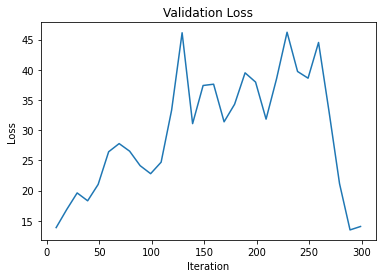

tensor(32.1689, device='cuda:0', dtype=torch.float64)

<Figure size 432x288 with 0 Axes>

In [ ]:
# FINAL_MODELS_PATH = "/content/drive/MyDrive/num_methods_project/final_models"
model = SCVNet().cuda()
model.load_state_dict(torch.load(f'{FINAL_MODELS_PATH}/scv_net_lr_5e-5_s_2_rmsprop.pkl'))
model.eval()

evalModel(model)

## ii) Using RMSProp optimizer with learning rate = 0.0005

Evaluating model on 300 images...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Iter = 9
Avg Validation loss = 20.226561601668827
--------------------------
Iter = 19
Avg Validation loss = 21.001937261201274
--------------------------
Iter = 29
Avg Validation loss = 22.010271456258554
--------------------------
Iter = 39
Avg Validation loss = 24.297480435923273
--------------------------
Iter = 49
Avg Validation loss = 27.319565098609516
--------------------------
Iter = 59
Avg Validation loss = 30.576917087003114
--------------------------
Iter = 69
Avg Validation loss = 33.29568866226488
--------------------------
Iter = 79
Avg Validation loss = 35.74992098802932
--------------------------
Iter = 89
Avg Validation loss = 37.47972988986202
--------------------------
Iter = 99
Avg Validation loss = 38.666223272700556
--------------------------
Iter = 109
Avg Validation loss = 39.49596328616446
--------------------------
Iter = 119
Avg Validation loss = 39.94644280736584
--------------------------
Iter = 129
Avg Validation loss = 40.48991500839526
-----------------

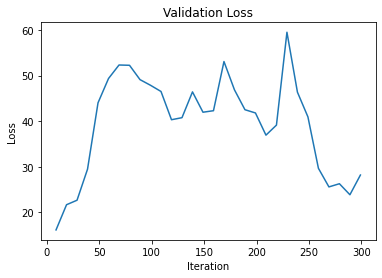

tensor(41.2264, device='cuda:0', dtype=torch.float64)

In [ ]:
model = SCVNet().cuda()
model.load_state_dict(torch.load(f'{FINAL_MODELS_PATH}/scv_net_lr=5e-4_rms_prop.pkl'))
model.eval()

evalModel(model)

## iii) Using RMSProp optimizer with learning rate = 0.005

Evaluating model on 300 images...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Iter = 9
Avg Validation loss = 78.23746649546185
--------------------------
Iter = 19
Avg Validation loss = 74.46477989449126
--------------------------
Iter = 29
Avg Validation loss = 73.81387933007107
--------------------------
Iter = 39
Avg Validation loss = 73.68388903288752
--------------------------
Iter = 49
Avg Validation loss = 74.6405443677062
--------------------------
Iter = 59
Avg Validation loss = 76.21837591898789
--------------------------
Iter = 69
Avg Validation loss = 77.54867559248241
--------------------------
Iter = 79
Avg Validation loss = 78.47152513440787
--------------------------
Iter = 89
Avg Validation loss = 79.13416286980858
--------------------------
Iter = 99
Avg Validation loss = 79.84700158167031
--------------------------
Iter = 109
Avg Validation loss = 80.56465816342029
--------------------------
Iter = 119
Avg Validation loss = 80.83959146309567
--------------------------
Iter = 129
Avg Validation loss = 80.09446030594924
-------------------------

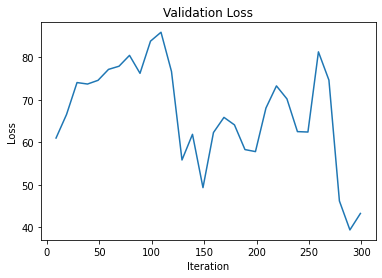

tensor(72.8781, device='cuda:0', dtype=torch.float64)

In [ ]:
model = SCVNet().cuda()
model.load_state_dict(torch.load(f'{FINAL_MODELS_PATH}/scv_net_lr=5e-3.rms_prop.pkl'))
model.eval()

evalModel(model)

## iv) using SGD optimizer with lr = 1e-5 and momentum param = 0.9, Stride = 2

Evaluation dev set...
(5, 3, 320, 768)
(5, 3, 320, 768)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  app.launch_new_instance()


(5, 3, 320, 768)
(5, 3, 320, 768)
(5, 3, 320, 768)
Iter = 9
[SCV-Net-0, 10] loss: 42.718
Iter time = 0.2457294464111328 (s)
--------------------------------------------
(5, 3, 320, 768)
(5, 3, 320, 768)
Iter = 19
[SCV-Net-0, 20] loss: 43.650
Iter time = 0.24651408195495605 (s)
--------------------------------------------
(5, 3, 320, 768)
(5, 3, 320, 768)
Iter = 29
[SCV-Net-0, 30] loss: 45.552
Iter time = 0.24763202667236328 (s)
--------------------------------------------
(5, 3, 320, 768)
(5, 3, 320, 768)
Iter = 39
[SCV-Net-0, 40] loss: 47.929
Iter time = 0.25069117546081543 (s)
--------------------------------------------
(5, 3, 320, 768)


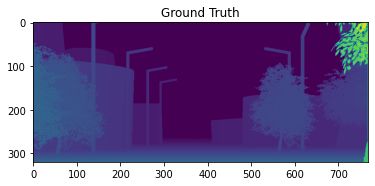

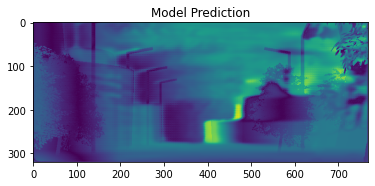

Iter = 49
[SCV-Net-0, 50] loss: 49.375
Iter time = 0.25176572799682617 (s)
--------------------------------------------
(5, 3, 320, 768)
(5, 3, 320, 768)
(5, 3, 320, 768)
Iter = 59
[SCV-Net-0, 60] loss: 49.256
Iter time = 0.25137853622436523 (s)
--------------------------------------------
(5, 3, 320, 768)
(5, 3, 320, 768)
Iter = 69
[SCV-Net-0, 70] loss: 49.174
Iter time = 0.2539536952972412 (s)
--------------------------------------------
(5, 3, 320, 768)
(5, 3, 320, 768)
Iter = 79
[SCV-Net-0, 80] loss: 48.708
Iter time = 0.2526261806488037 (s)
--------------------------------------------
(5, 3, 320, 768)
(5, 3, 320, 768)
Iter = 89
[SCV-Net-0, 90] loss: 46.729
Iter time = 0.2525207996368408 (s)
--------------------------------------------
(5, 3, 320, 768)


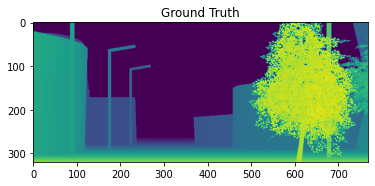

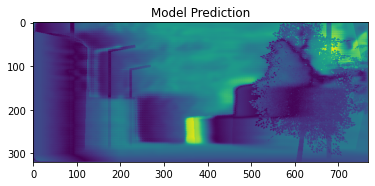

(5, 3, 320, 768)
Iter = 99
[SCV-Net-0, 100] loss: 45.478
Iter time = 0.25272655487060547 (s)
--------------------------------------------
(5, 3, 320, 768)
(5, 3, 320, 768)
Iter = 109
[SCV-Net-0, 110] loss: 44.551
Iter time = 0.2494189739227295 (s)
--------------------------------------------
(5, 3, 320, 768)
(5, 3, 320, 768)
Iter = 119
[SCV-Net-0, 120] loss: 41.813
Iter time = 0.25038719177246094 (s)
--------------------------------------------
(5, 3, 320, 768)
(5, 3, 320, 768)
Iter = 129
[SCV-Net-0, 130] loss: 39.689
Iter time = 0.2466905117034912 (s)
--------------------------------------------
(5, 3, 320, 768)
(5, 3, 320, 768)
Iter = 139
[SCV-Net-0, 140] loss: 47.491
Iter time = 0.2464737892150879 (s)
--------------------------------------------
(5, 3, 320, 768)


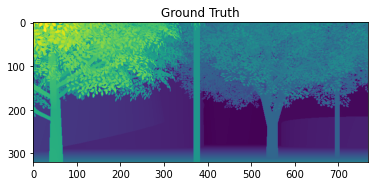

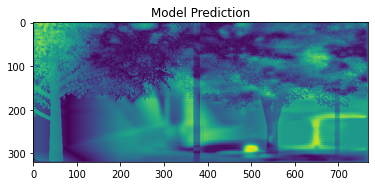

Iter = 149
[SCV-Net-0, 150] loss: 46.970
Iter time = 0.24685168266296387 (s)
--------------------------------------------
(5, 3, 320, 768)
(5, 3, 320, 768)
Iter = 159
[SCV-Net-0, 160] loss: 44.898
Iter time = 0.2454538345336914 (s)
--------------------------------------------
(5, 3, 320, 768)
(5, 3, 320, 768)
(5, 3, 320, 768)
Iter = 169
[SCV-Net-0, 170] loss: 39.639
Iter time = 0.2453136444091797 (s)
--------------------------------------------
(5, 3, 320, 768)
(5, 3, 320, 768)
Iter = 179
[SCV-Net-0, 180] loss: 39.487
Iter time = 0.24640703201293945 (s)
--------------------------------------------
(5, 3, 320, 768)
(5, 3, 320, 768)
Iter = 189
[SCV-Net-0, 190] loss: 40.332
Iter time = 0.24649405479431152 (s)
--------------------------------------------
(5, 3, 320, 768)


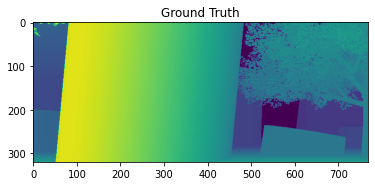

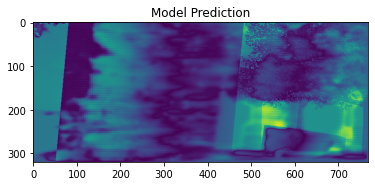

Iter = 199
[SCV-Net-0, 200] loss: 41.661
Iter time = 0.24346423149108887 (s)
--------------------------------------------
(5, 3, 320, 768)
(5, 3, 320, 768)
(5, 3, 320, 768)
Iter = 209
[SCV-Net-0, 210] loss: 42.986
Iter time = 0.24265646934509277 (s)
--------------------------------------------
(5, 3, 320, 768)
(5, 3, 320, 768)
Iter = 219
[SCV-Net-0, 220] loss: 47.499
Iter time = 0.2445065975189209 (s)
--------------------------------------------
(5, 3, 320, 768)
(5, 3, 320, 768)
Iter = 229
[SCV-Net-0, 230] loss: 50.266
Iter time = 0.2427074909210205 (s)
--------------------------------------------
(5, 3, 320, 768)
(5, 3, 320, 768)
Iter = 239
[SCV-Net-0, 240] loss: 48.298
Iter time = 0.24211525917053223 (s)
--------------------------------------------
(5, 3, 320, 768)


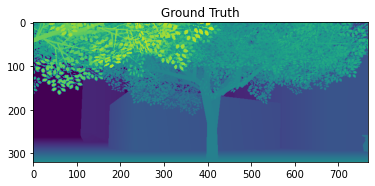

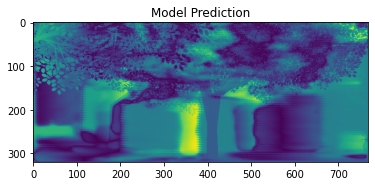

Iter = 249
[SCV-Net-0, 250] loss: 47.963
Iter time = 0.24317622184753418 (s)
--------------------------------------------
(5, 3, 320, 768)
(5, 3, 320, 768)
(5, 3, 320, 768)
Iter = 259
[SCV-Net-0, 260] loss: 47.241
Iter time = 0.2446908950805664 (s)
--------------------------------------------
(5, 3, 320, 768)
(5, 3, 320, 768)
Iter = 269
[SCV-Net-0, 270] loss: 47.742
Iter time = 0.24068045616149902 (s)
--------------------------------------------
(5, 3, 320, 768)
(5, 3, 320, 768)
Iter = 279
[SCV-Net-0, 280] loss: 46.518
Iter time = 0.24194812774658203 (s)
--------------------------------------------
(5, 3, 320, 768)
Iter = 289
[SCV-Net-0, 290] loss: 43.341
Iter time = 0.24325156211853027 (s)
--------------------------------------------


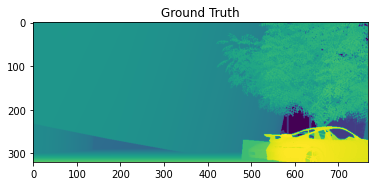

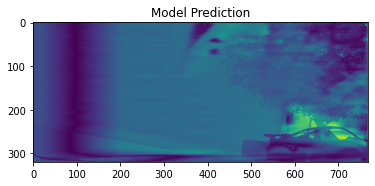

Iter = 299
[SCV-Net-0, 300] loss: 41.992
Iter time = 0.24245476722717285 (s)
--------------------------------------------
Done!
Eval loss: 45.29826839384288


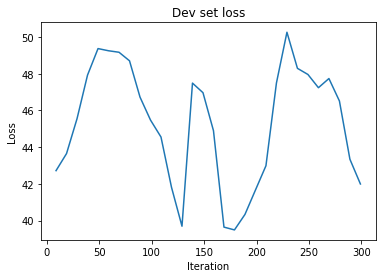

<Figure size 432x288 with 0 Axes>

In [ ]:
FINAL_MODELS_PATH = "/content/drive/MyDrive/num_methods_project/final_models"
model = SCVNet().cuda()
model.load_state_dict(torch.load(f'{FINAL_MODELS_PATH}/params_SCV_Net_SGD_lr_5e-5_momentum.pkl'))
model.eval()

evalModel(model)

## v) Using Ada Delta optimizer with rho = 0.9, eps = 1e-6, weight_decay = 0.001, Stride = 2

Evaluating model on 300 images...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Iter = 9
Avg Validation loss = 87.90263615725922
--------------------------
Iter = 19
Avg Validation loss = 82.76606327435292
--------------------------
Iter = 29
Avg Validation loss = 80.72300983179821
--------------------------
Iter = 39
Avg Validation loss = 78.76894225918954
--------------------------
Iter = 49
Avg Validation loss = 76.93426618279271
--------------------------
Iter = 59
Avg Validation loss = 75.97239380069048
--------------------------
Iter = 69
Avg Validation loss = 75.38803751418459
--------------------------
Iter = 79
Avg Validation loss = 74.88547300529586
--------------------------
Iter = 89
Avg Validation loss = 75.1101936862945
--------------------------
Iter = 99
Avg Validation loss = 75.4938235497399
--------------------------
Iter = 109
Avg Validation loss = 75.15829422865289
--------------------------
Iter = 119
Avg Validation loss = 74.58301220928297
--------------------------
Iter = 129
Avg Validation loss = 75.39007097965501
--------------------------

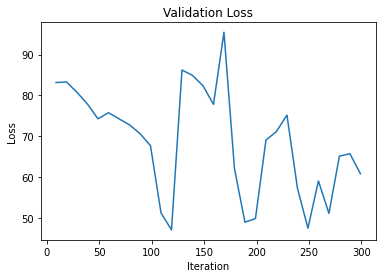

tensor(78.0491, device='cuda:0', dtype=torch.float64)

In [ ]:
FINAL_MODELS_PATH = "/content/drive/MyDrive/num_methods_project/final_models"
model = SCVNet().cuda()
model.load_state_dict(torch.load(f'{FINAL_MODELS_PATH}/params_SCV_Net_Adadelta.pkl'))
model.eval()

evalModel(model)

## vi) Using Adam optimizer with learning rate = 1e-5, Stride = 2

Observation: Using this optimizer, the runtime is only slightly better but the loss is only slightly worse as compared to Ada Delta. Both Adam and Ada delta have very similar performance.

Evaluating model on 300 images...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Iter = 9
Avg Validation loss = 88.19727923145298
--------------------------
Iter = 19
Avg Validation loss = 83.09680768368253
--------------------------
Iter = 29
Avg Validation loss = 80.99846295791586
--------------------------
Iter = 39
Avg Validation loss = 78.98523509125563
--------------------------
Iter = 49
Avg Validation loss = 77.11360100640762
--------------------------
Iter = 59
Avg Validation loss = 76.12213024190439
--------------------------
Iter = 69
Avg Validation loss = 75.51903499086539
--------------------------
Iter = 79
Avg Validation loss = 75.01666183587952
--------------------------
Iter = 89
Avg Validation loss = 75.25768580840135
--------------------------
Iter = 99
Avg Validation loss = 75.65075510803399
--------------------------
Iter = 109
Avg Validation loss = 75.32527719687764
--------------------------
Iter = 119
Avg Validation loss = 74.74446748255536
--------------------------
Iter = 129
Avg Validation loss = 75.53889117756896
------------------------

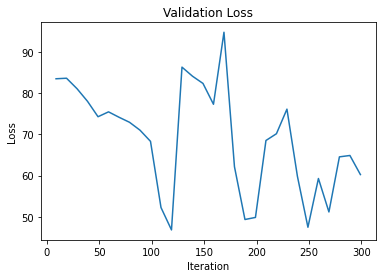

tensor(78.0498, device='cuda:0', dtype=torch.float64)

In [ ]:
FINAL_MODELS_PATH = "/content/drive/MyDrive/num_methods_project/final_models"
model = SCVNet().cuda()
model.load_state_dict(torch.load(f'{FINAL_MODELS_PATH}/params_SCV_Net_ADAM.pkl'))
model.eval()

evalModel(model)

# Testing our model

### Apply best performing model to the test set and evaluate performance metrics:

Testting model on 300 images...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Iter = 9
Avg test loss = 23.682524901827097
--------------------------
Iter = 19
Avg test loss = 25.546820690295284
--------------------------
Iter = 29
Avg test loss = 26.056349441537936
--------------------------
Iter = 39
Avg test loss = 27.083530130636813
--------------------------
Iter = 49
Avg test loss = 28.338397960314047


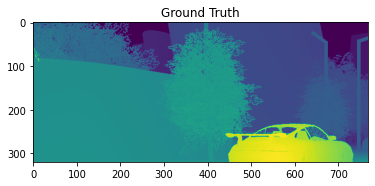

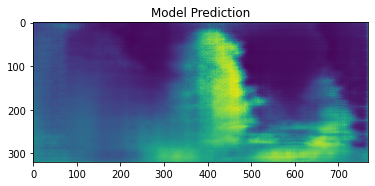

--------------------------
Iter = 59
Avg test loss = 29.752683115520906
--------------------------
Iter = 69
Avg test loss = 30.6923937042669
--------------------------
Iter = 79
Avg test loss = 30.823782866082386
--------------------------
Iter = 89
Avg test loss = 31.201759020372375
--------------------------
Iter = 99
Avg test loss = 31.785869651575315


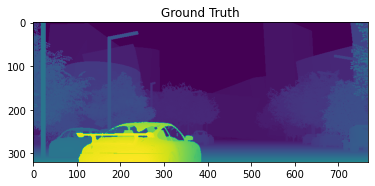

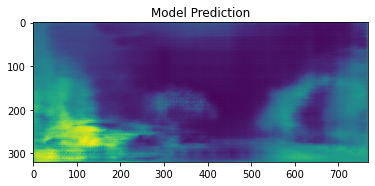

--------------------------
Iter = 109
Avg test loss = 32.32301408523003
--------------------------
Iter = 119
Avg test loss = 32.6787415563814
--------------------------
Iter = 129
Avg test loss = 32.93922437709884
--------------------------
Iter = 139
Avg test loss = 33.24949659070884
--------------------------
Iter = 149
Avg test loss = 33.55608734318474


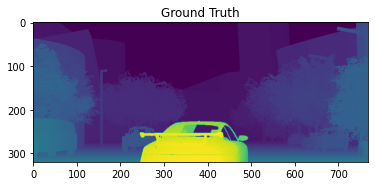

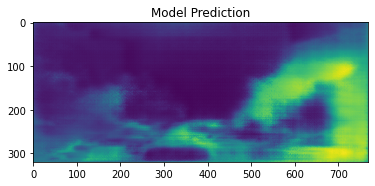

--------------------------
Iter = 159
Avg test loss = 33.93267906325819
--------------------------
Iter = 169
Avg test loss = 34.32971467646914
--------------------------
Iter = 179
Avg test loss = 34.44931488728145
--------------------------
Iter = 189
Avg test loss = 34.42753592570921
--------------------------
Iter = 199
Avg test loss = 34.734500821541694


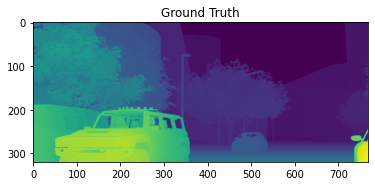

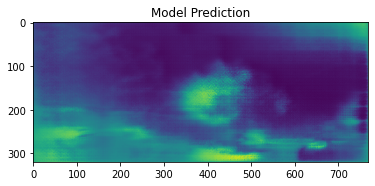

--------------------------
Iter = 209
Avg test loss = 35.500126417502884
--------------------------
Iter = 219
Avg test loss = 35.90127059549465
--------------------------
Iter = 229
Avg test loss = 35.9616580977905
--------------------------
Iter = 239
Avg test loss = 35.815288112379356
--------------------------
Iter = 249
Avg test loss = 35.57861769730564


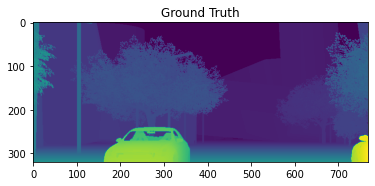

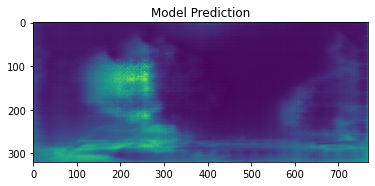

--------------------------
Iter = 259
Avg test loss = 35.429559989738145
--------------------------
Iter = 269
Avg test loss = 35.56553567567894
--------------------------
Iter = 279
Avg test loss = 35.74965207508915
--------------------------
Iter = 289
Avg test loss = 35.72066125129403
--------------------------
Iter = 299
Avg test loss = 35.63068848904141


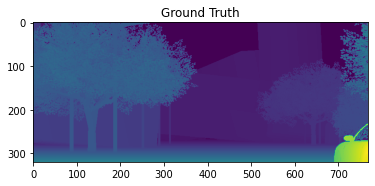

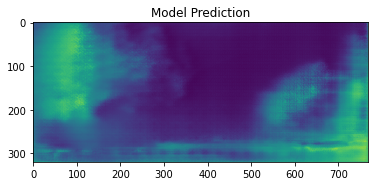

--------------------------
Avg validation loss: 35.51191952741127
Eval on 300 images done in 110.68588018417358 (s)


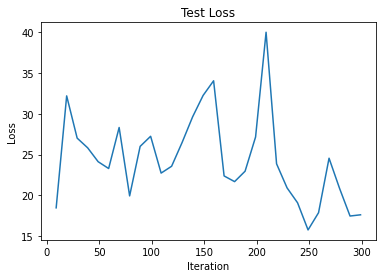

tensor(35.5119, device='cuda:0', dtype=torch.float64)

<Figure size 432x288 with 0 Axes>

In [ ]:
testModel(model)